# 1. Convert Sentinel-2 Grid KML to Geoparquet

In [1]:
import geopandas as gpd
from shapely import wkt
import utils
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Load KML file directly from URL
gdf = gpd.read_file(utils.URL_ESA_S2_GRID_KML, 
                    engine="pyogrio", force_2d=True, 
                    layer='Features',
                    columns=["Name", "description", "geometry"])
gdf.rename(columns=dict(Name='tile'), inplace=True)
gdf.head()

,tile,description,geometry
0,01CCV,TILE PROPERTIES<br><table border=0 cellpadding...,"GEOMETRYCOLLECTION (POLYGON ((180 -73.05974, 1..."
1,01CDH,TILE PROPERTIES<br><table border=0 cellpadding...,"GEOMETRYCOLLECTION (POLYGON ((180 -83.80855, 1..."
2,01CDJ,TILE PROPERTIES<br><table border=0 cellpadding...,"GEOMETRYCOLLECTION (POLYGON ((180 -82.91344, 1..."
3,01CDK,TILE PROPERTIES<br><table border=0 cellpadding...,"GEOMETRYCOLLECTION (POLYGON ((180 -82.01866, 1..."
4,01CDL,TILE PROPERTIES<br><table border=0 cellpadding...,"GEOMETRYCOLLECTION (POLYGON ((180 -81.12317, 1..."


In [3]:
# Convert geometries to MultiPolygon and extract center Point
gdf['center'] = gdf.geometry.apply(lambda x: utils.center_from_geoms(x.geoms))
gdf['geometry'] = gdf.geometry.apply(lambda x: utils.multipolygon_from_geoms(x.geoms))

# Extract UTM_WKT and EPSG from "Description" column
gdf['epsg'] = gdf.apply(utils.get_epsg, axis=1)
gdf['utm_wkt'] = gdf.apply(utils.get_utm_wkt, axis=1)

# Add simple UTM bounds (left, down, right, up)
gdf['utm_bounds'] = gdf.utm_wkt.apply(lambda x: wkt.loads(x).bounds).astype(str)

# Drop description column 
gdf = gdf.drop(columns=['description'])
gdf.head()

,tile,geometry,center,epsg,utm_wkt,utm_bounds
0,01CCV,"MULTIPOLYGON (((180 -73.05974, 176.86462 -72.9...",POINT (178.43231 -72.53611),32701,"POLYGON ((300000 2000020,300000 1890220,409800...","(300000.0, 1890220.0, 409800.0, 2000020.0)"
1,01CDH,"MULTIPOLYGON (((180 -83.80855, 174.71288 -83.7...",POINT (177.35644 -83.30263),32701,"POLYGON ((399960 800020,399960 690220,509760 6...","(399960.0, 690220.0, 509760.0, 800020.0)"
2,01CDJ,"MULTIPOLYGON (((180 -82.91344, 175.74819 -82.8...",POINT (177.87409 -82.41019),32701,"POLYGON ((399960 900040,399960 790240,509760 7...","(399960.0, 790240.0, 509760.0, 900040.0)"
3,01CDK,"MULTIPOLYGON (((180 -82.01866, 176.5527 -81.99...",POINT (-178.18419 -81.53983),32701,"POLYGON ((399960 1000000,399960 890200,509760 ...","(399960.0, 890200.0, 509760.0, 1000000.0)"
4,01CDL,"MULTIPOLYGON (((180 -81.12317, 177.19616 -81.1...",POINT (-178.21593 -80.64403),32701,"POLYGON ((399960 1100020,399960 990220,509760 ...","(399960.0, 990220.0, 509760.0, 1100020.0)"


In [4]:
print(f"Number of tiles: {len(gdf)}")
gdf.to_parquet("sentinel-2-grid.parquet")

Number of tiles: 56686


# 2. Filter for tiles over land

<Axes: >

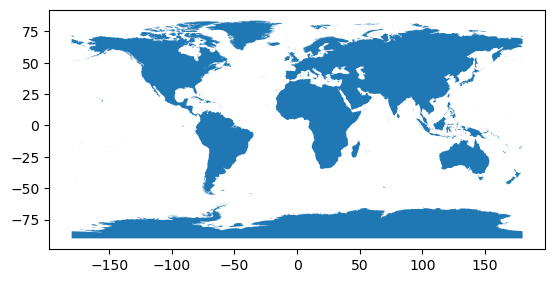

In [ ]:
# Load high resolution land mask directly from URL
land_highres = gpd.read_file(utils.URL_NE_VEC_10m_LAND_GEOJSON, engine="pyogrio")
land_highres.plot()

In [ ]:
%%time
land = utils.union_query_strtree(gdf=gdf, gdf_to_query=land_highres, predicate='intersects')
gdf_land = gdf.iloc[land].reset_index(drop=True)
gdf_land.head()

CPU times: user 2.32 s, sys: 121 ms, total: 2.45 s
Wall time: 2.45 s


,tile,geometry,center,epsg,utm_wkt,utm_bounds
0,01CEH,"POLYGON ((-177.00144 -82.85238, -169.14642 -82...",POINT (-172.46025 -83.31068),32701,"POLYGON ((499980 800020,499980 690220,609780 6...","(499980.0, 690220.0, 609780.0, 800020.0)"
1,01CEJ,"POLYGON ((-177.00128 -81.95638, -170.00719 -81...",POINT (-173.02608 -82.41844),32701,"POLYGON ((499980 900040,499980 790240,609780 7...","(499980.0, 790240.0, 609780.0, 900040.0)"
2,01FBE,"MULTIPOLYGON (((180 -50.59941, 178.76332 -50.5...",POINT (179.38166 -50.08856),32701,"POLYGON ((199980 4500040,199980 4390240,309780...","(199980.0, 4390240.0, 309780.0, 4500040.0)"
3,01FBF,"MULTIPOLYGON (((180 -49.70001, 178.84184 -49.6...",POINT (179.42092 -49.19043),32701,"POLYGON ((199980 4600000,199980 4490200,309780...","(199980.0, 4490200.0, 309780.0, 4600000.0)"
4,01GBH,"MULTIPOLYGON (((180 -47.89995, 178.98771 -47.8...",POINT (179.49385 -47.39267),32701,"POLYGON ((199980 4800040,199980 4690240,309780...","(199980.0, 4690240.0, 309780.0, 4800040.0)"


In [7]:
print(f"Number of tiles: {len(gdf_land)}")
gdf_land.to_parquet("sentinel-2-grid_LAND.parquet")

Number of tiles: 20430
